In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('data/training_cleaned.csv')

In [3]:
for col in df.columns:
    if df[col].dtype != np.float_:
        print('Unique values for {}: {}'.format(col, len(np.unique(df[col]))))

Unique values for Unnamed: 0: 4958347
Unique values for srch_id: 199795
Unique values for date_time: 198615
Unique values for site_id: 34
Unique values for visitor_location_country_id: 210
Unique values for prop_country_id: 172
Unique values for prop_id: 129113
Unique values for prop_starrating: 6
Unique values for prop_brand_bool: 2
Unique values for position: 40
Unique values for promotion_flag: 2
Unique values for srch_destination_id: 18127
Unique values for srch_length_of_stay: 36
Unique values for srch_booking_window: 429
Unique values for srch_adults_count: 9
Unique values for srch_children_count: 10
Unique values for srch_room_count: 8
Unique values for srch_saturday_night_bool: 2
Unique values for random_bool: 2
Unique values for click_bool: 2
Unique values for booking_bool: 2


In [4]:
# NOTE: What do we do with the groups that have no booking????
booked = list(df.groupby('srch_id')['booking_bool'].agg('sum'))
booked = [1 if booking > 0 else 0 for booking in booked]
clicked = list(df.groupby('srch_id')['click_bool'].agg('sum'))
clicked = [1 if clicks > 0 else 0 for clicks in clicked]

print('Percentage of searches that resulted in a booking: {:.2f}%'.format(sum(booked) / len(booked) * 100))
print('Percentage of searches that resulted in a click: {:.2f}%'.format(sum(clicked) / len(clicked) * 100))
print('Amount of distinct searches: {}'.format(len(np.unique(np.array(df['srch_id'])))))

Percentage of searches that resulted in a booking: 69.27%
Percentage of searches that resulted in a click: 100.00%
Amount of distinct searches: 199795


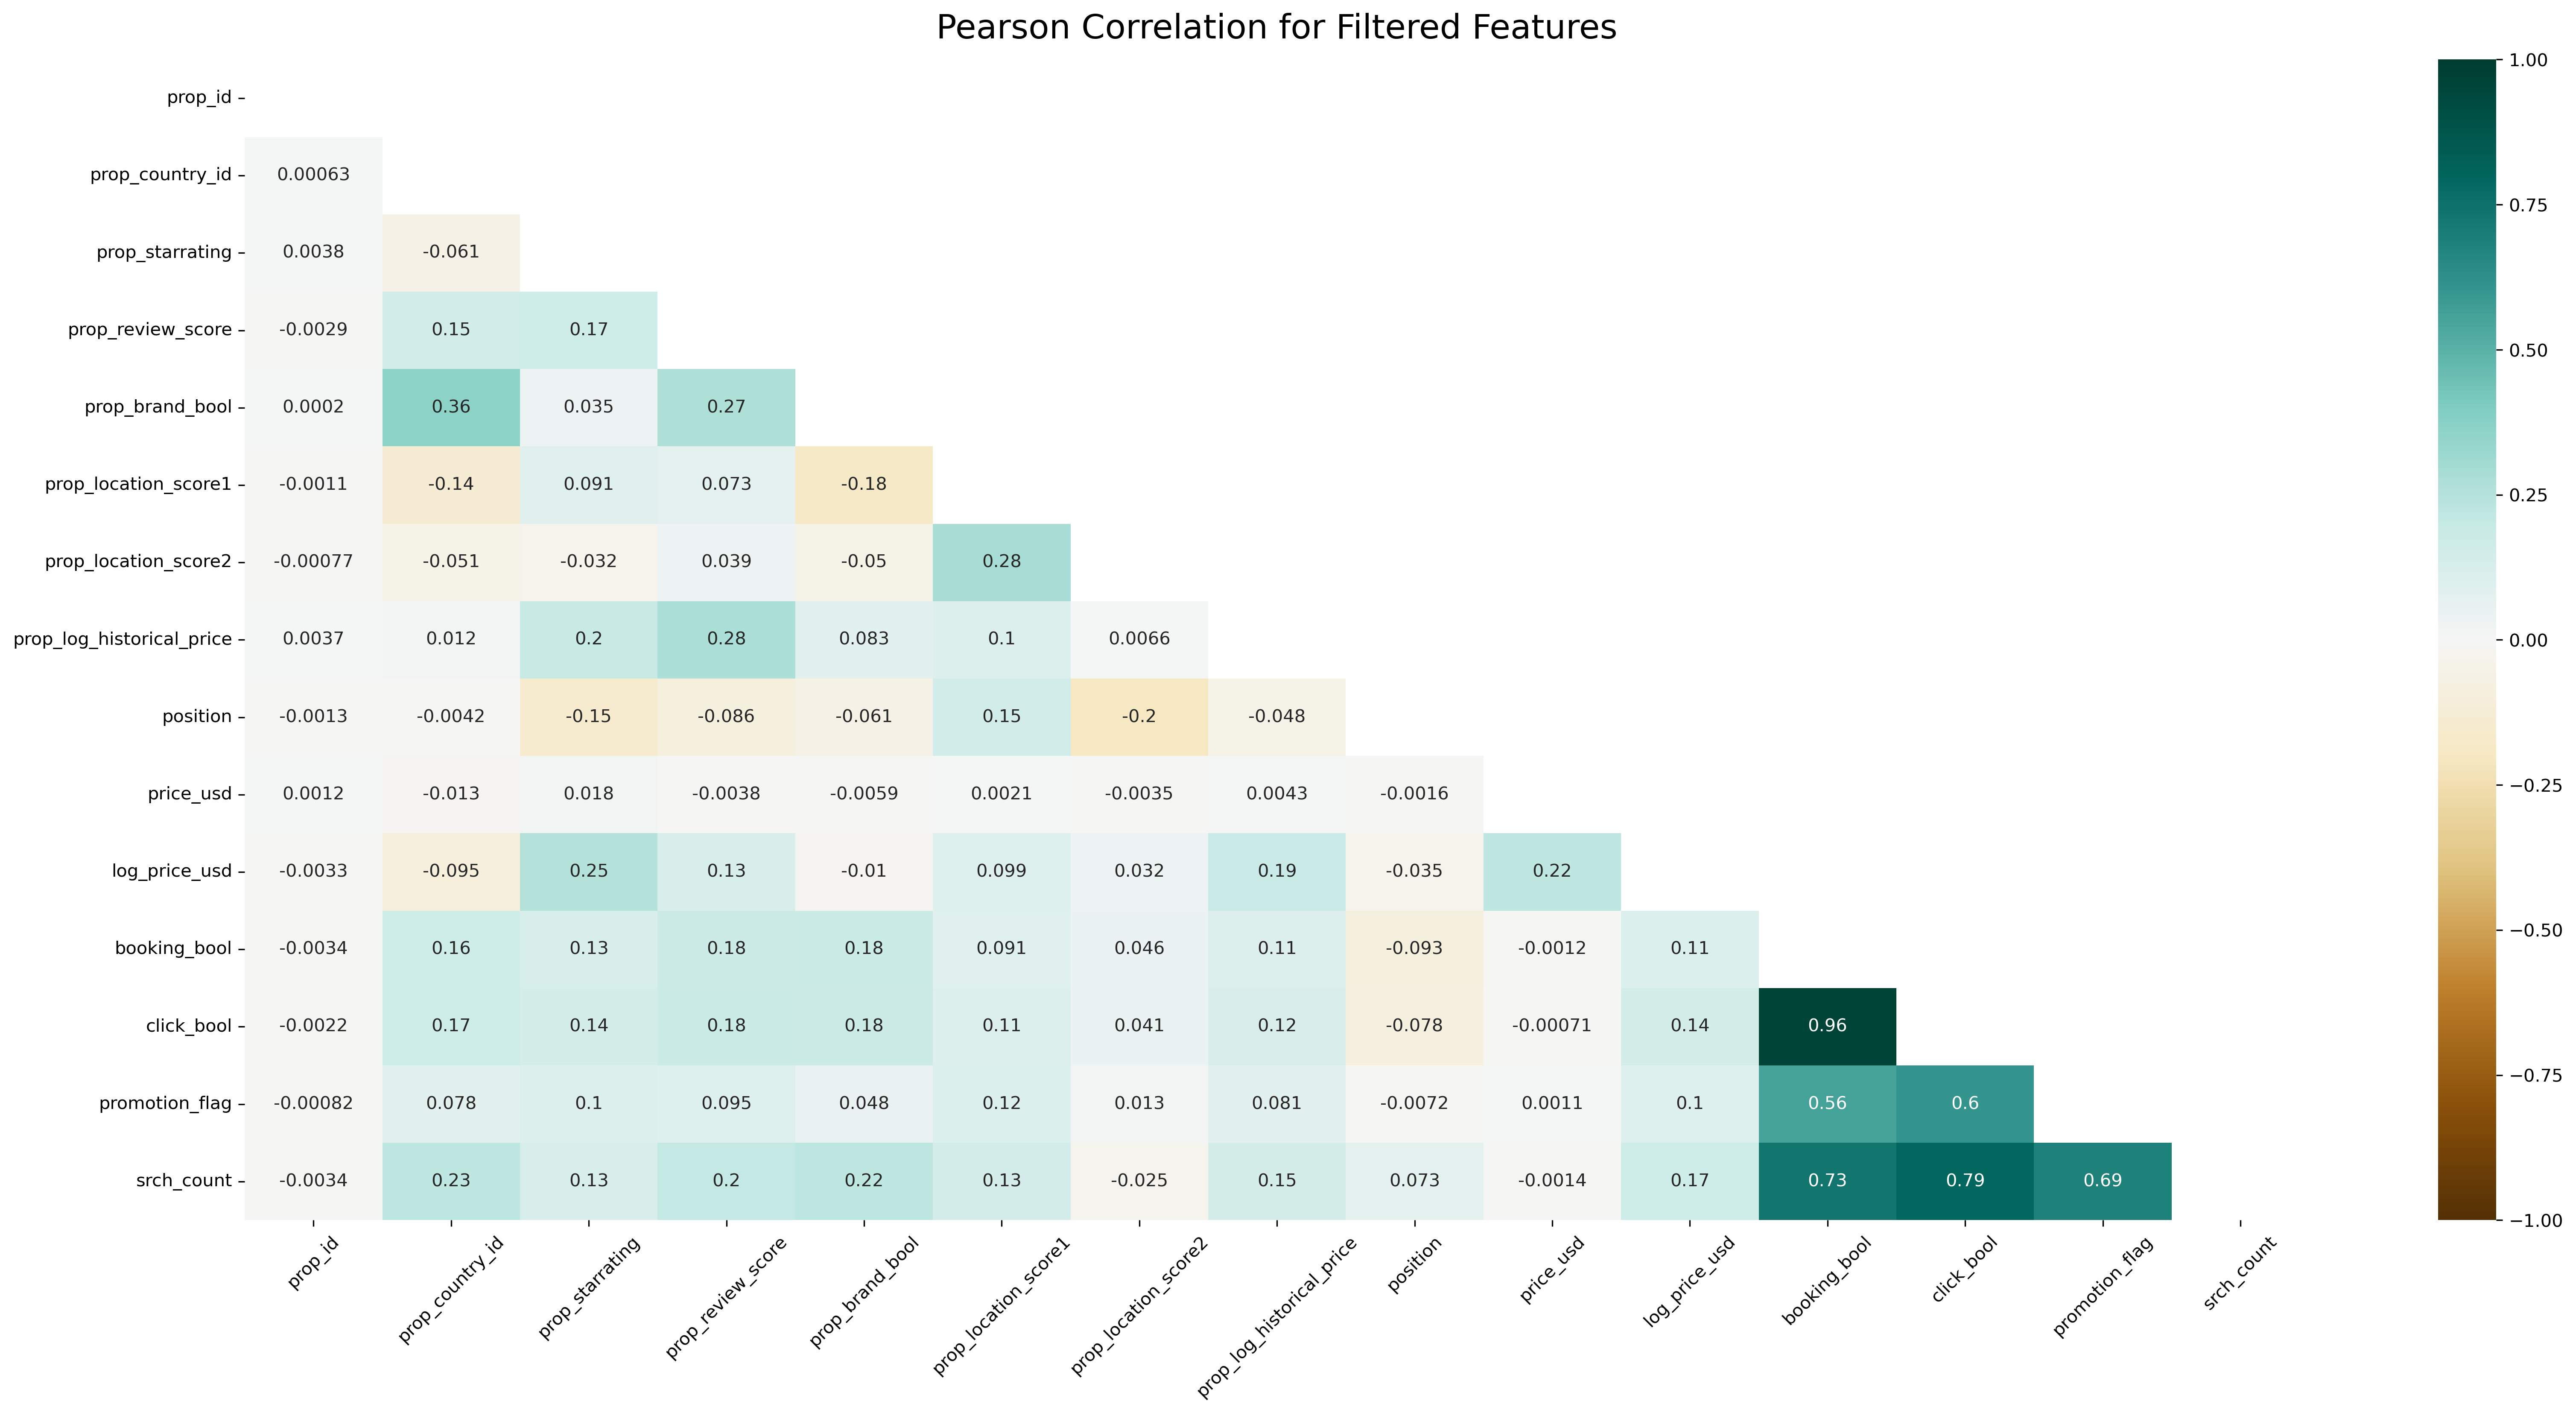

In [5]:
# Plot the correlation heatmap of all features.
df_hotel = pd.read_csv('data/hotel_data.csv')
# df_corr = df.join(df_hotel.set_index('prop_id'), lsuffix='agg_', on='prop_id')
df_corr = df_hotel.corr()
msk = np.triu(np.ones_like(df_corr))

plt.figure(figsize=(26, 12), dpi=300) 
ax = heatmap = sns.heatmap(df_corr, mask=msk, vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"fontsize":10})

# ax.tick_params(labelsize=16)

cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=15)

heatmap.set_title('Pearson Correlation for Filtered Features', fontdict={'fontsize':19}, pad=12)
# plt.tight_layout()
plt.xticks(rotation=45) 
plt.savefig('pearson_vars.pdf')

In [6]:
''''From https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html'''

hotel_pop = pd.read_csv('data/hotel_popularity.csv')
df_features = df.join(hotel_pop.set_index('prop_id'), on='prop_id')
df_features['booking_hist'] = np.log(df_features['booking_hist'] + 1)
df_features['click_hist'] = np.log(df_features['click_hist'] + 1)
tmp = df_features['booking_bool']
df_data = df_features.drop(['date_time', 'click_bool', 'Unnamed: 0', 'booking_bool'], axis=1)
df_data['booking_bool'] = tmp

data = df_data.to_numpy()
X = data[:, :-1]
y = data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
feature_names = df.columns[:-1]

forest = RandomForestClassifier(random_state=0, n_estimators=25, max_depth=13, verbose=3, n_jobs=4)
forest.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 2 of 25building tree 3 of 25building tree 4 of 25

building tree 1 of 25

building tree 5 of 25
building tree 6 of 25
building tree 7 of 25
building tree 8 of 25
building tree 9 of 25
building tree 10 of 25
building tree 11 of 25
building tree 12 of 25
building tree 13 of 25
building tree 14 of 25
building tree 15 of 25
building tree 16 of 25
building tree 17 of 25
building tree 18 of 25
building tree 19 of 25
building tree 20 of 25
building tree 21 of 25
building tree 22 of 25
building tree 23 of 25
building tree 24 of 25
building tree 25 of 25


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  2.4min finished


RandomForestClassifier(max_depth=13, n_estimators=25, n_jobs=4, random_state=0,
                       verbose=3)

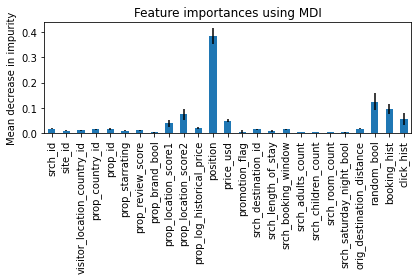

In [7]:
result = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# result = permutation_importance(
#     forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=4
# )
forest_importances = pd.Series(result, index=df_data.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [9]:
foo = df.drop(['date_time', 'click_bool', 'Unnamed: 0', 'booking_bool'], axis=1)
foo.head(5)

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool
0,1,12,187,219,893,3,3.5,1,2.83,0.0438,...,0,23246,1,0,4,0,1,1,1301.234406,1
1,1,12,187,219,10404,4,4.0,1,2.20,0.0149,...,0,23246,1,0,4,0,1,1,1301.234406,1
2,1,12,187,219,21315,3,4.5,1,2.20,0.0245,...,0,23246,1,0,4,0,1,1,1301.234406,1
3,1,12,187,219,27348,2,4.0,1,2.83,0.0125,...,0,23246,1,0,4,0,1,1,1301.234406,1
4,1,12,187,219,29604,4,3.5,1,2.64,0.1241,...,0,23246,1,0,4,0,1,1,1301.234406,1
